# RandomForests for RNASeq expression classification

# 1. Introduction 

There are three main categories of machine learning. Unsupervised, supervised, and reinforcement learning. Random forest classification is a typical supervised learning method. Supervised learning is a task of learning a function that maps output to corresponding input based on example input-output pairs.[1] There's always labeled training data, from which algorithms and rules can be drawn to predict class labels of unseen samples. 


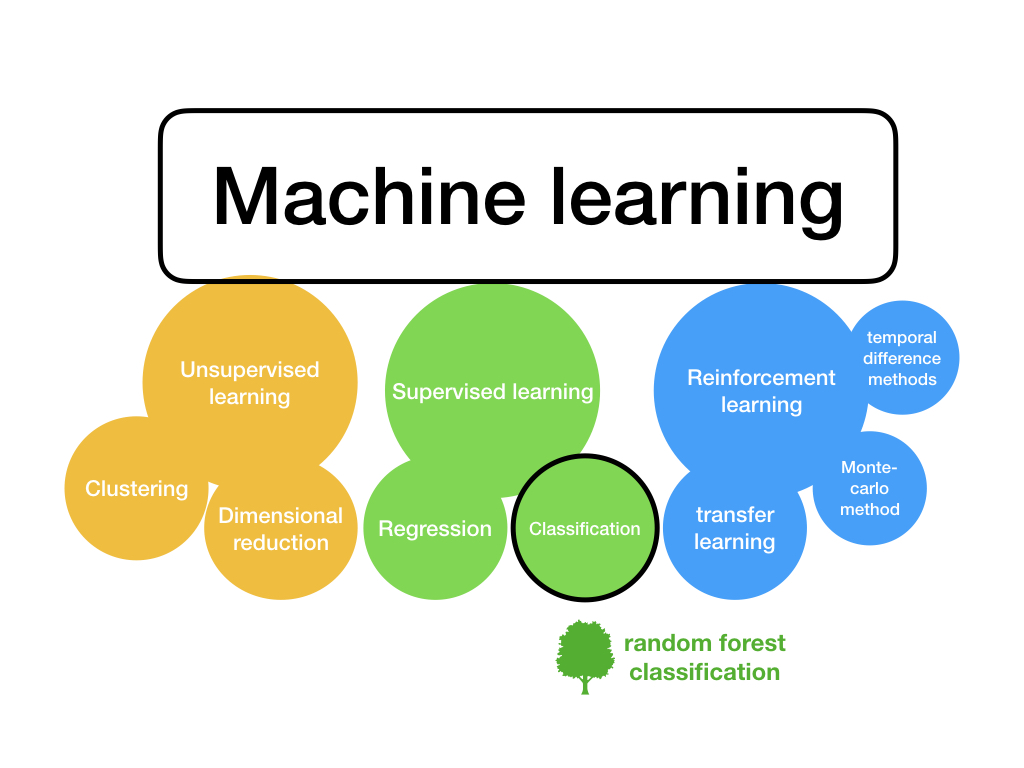

##### Quick terminology of machine learning: features, labels, missing data


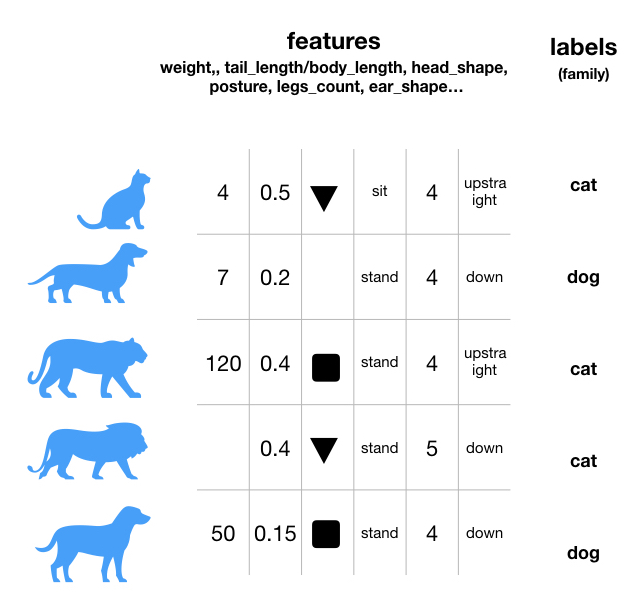

### Random Forest
The random forest is a supervised learning algorithm that randomly creates and merges multiple decision trees into one “forest.” The goal is not to rely on a single learning model, but rather a collection of decision models to improve accuracy. The primary difference between these decision models and the standard decision tree algorithms is that the root nodes feature splitting nodes are generated randomly.[2]

Random forest classifiers can serve both classification and regressional purposes. It can deal with a wide range of data types, both categorical and numerical data types, and missing values are allowed in a random forest classifier. 

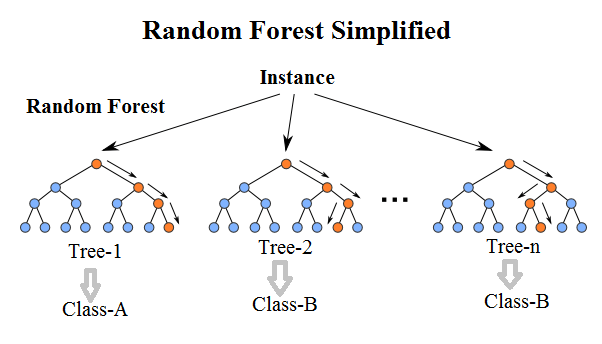

Reference:
1. Supervised learning, Wikipedia, retrieved on 2020/03/09, link:https://en.wikipedia.org/wiki/Supervised_learning
2. Random forest, DeepAI, retrieved on 2020/03/09, link: https://deepai.org/machine-learning-glossary-and-terms/random-forest
3. Random Forest Simple Explanation
, Wil Koehrsen, retrieved on 2020/03/09 from https://medium.com/@williamkoehrsen/random-forest-simple-explanation-377895a60d2d

# 2.1 Getting started

Here, we import python packages for data frame management, number/ array management, machine learning, and plotting. You could find the packages and their descriptions on the PyPI "project links - homepage", for example pandas:
- https://pypi.org/project/pandas/
- https://pandas.pydata.org/


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

AttributeError: module 'numpy' has no attribute '__version__'

# 2.2 The dataset

In this session we will use an miRNA expression dataset that contains 714 expression signatures across 29 tumor/normal pairs measured in human cervical tissue. 

We will use this dataset to perform several pre-processing steps, feature scaling/normalization and to train a RandomForest classifier with Python.

First, let's import our dataset and have a look at the data.

In [5]:
try:
    exprm = pd.read_csv("./datasets/exprm.txt", sep="\t")
except Exception:
    print("An error occured while reading the data")

An error occured while reading the data


In [6]:
exprm = pd.read_csv("./datasets/exprm.txt", sep="\t")

NameError: name 'pd' is not defined

Print the first 5 rows.

In [4]:
exprm.head(n=5)

N1    N2    N3     N4    N5   N6  N7    N8    N9    N10  ...  T20  \
let-7a   865   810  5505   6692  1456  588   9  4513  1962  10167  ...   37   
let-7a*    3    12    30     73     6    2   0   199    10    173  ...    0   
let-7b   975  2790  4912  24286  1759  508  33  6162  1455  18110  ...   99   
let-7b*   15    18    27    119    11    3   0   116    17    233  ...    0   
let-7c   828  1251  2973   6413   713  339  23  2002   476   3294  ...   34   

            T21  T22    T23  T24    T25    T26    T27  T28   T29  
let-7a     3174  116   1722   68  12121  14398  39196  198  1422  
let-7a*     648    4    212    6      2     80    164   18     1  
let-7b   102358  184  28274  401  14471  24097  73139  669  2492  
let-7b*     334    1    189    5     34    115    230    4    15  
let-7c     1711   22   3127  199   3186   1454   5883  167   321  

[5 rows x 58 columns]

### Question
- What is the dimension of the dataset above/ what type of numerical data does it contain?
- Which dimenson contains the features, which one the instances? 

#### TIp 
You can access a dataframe's dimension with the `dim()` function.

# 2.3 Pre-proccesing -  Normalization

A common normalization technique in RNASEq is the Median of Ratios method, which is used by [DESeq2](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-014-0550-8), one of the  major statistical tools for differential expression analysis. Briefly, this method corrects for differences in sequencing library size (number of reads), composition of the library (tissue specific expression) to make samples comparable. Without accounting for these confounding factors, a classifier might discriminate between samples based on technical variation which mask the true biological signal. 

Here we implement our own version of the Median of Ratios method. However, several more RNA sepecific normalization methods exist, such as Trimmed Mean (TMM) for example.


First, we perform a log transformation on the raw read counts to reduce the skewness of the dataset

In [18]:
exprm_log2 = exprm.apply(np.log2) # Perform a log transformation of our dataset.

In the following step, we calculate the mean for each miRNA expression across all samples

In [19]:
expr_means =  exprm_log2.apply(np.mean,1) # Calculate the geometric mean for each gene

Some samples might contains 0 (-inf) counts which we need to filter first before proceeding.

In [20]:
idxs = expr_means > 0 # Filter 0 Counts values
expr_means = expr_means[idxs] # Select geometric means with > 0 expression.

Next, we caclulate the row-wise mean to expression ratio for each sample across all miRNA. T

In [21]:
mean_ratio = exprm_log2[idxs].sub(expr_means,"index") # Calculate mean expr. ratios for each gene's expression per sample.

We select the media ration per miRNA which becomes our size factor. These size factors serve as a "pseudo" references to normalize our raw read_counts.

In [22]:
size_factors = mean_ratio.apply(lambda counts: np.median(counts),1) # Select median ratio for normalization

Finally, we divide each miRNA expression (per sample) by its corresponding size factor.

In [23]:
exprm_normalized = exprm[idxs].divide(np.exp(size_factors),'index')

N1           N2           N3            N4  \
let-7a        461.133238   431.812627  2934.726560   3567.518645   
let-7b        824.339370  2358.878812  4152.979471  20533.236858   
let-7c        519.774909   785.312090  1866.293240   4025.744551   
let-7d         53.624715    74.017212   274.921074   1427.474808   
let-7e        113.030646   100.991879   527.030466   3879.827071   
let-7f        272.521920    91.958188  1674.884280   6938.053670   
let-7g        228.290651    88.354100   981.598729   2074.533838   
let-7i        192.462612   242.774416   728.323247   3088.186400   
miR-100        93.418331    67.758360   275.042812    140.728903   
miR-101        74.333529   126.226747   378.212734    377.277721   
miR-10b        81.117440    61.842009   163.038023   1659.293376   
miR-125a-5p   178.641002   563.711605   570.327939   1386.783480   
miR-125b     1062.872332  5126.976655  2657.180831   8228.556900   
miR-126       286.277908   187.326969   876.206789   2895.259157   
miR-142-5p      5.005906    17.020079    28.033071     99.116930   
miR-143      3896.234411  6847.221266  7078.322647  31494.152820   
miR-145       290.564935   788.676251   935.717586   2465.228889   
miR-151-5p    244.103083   545.903258   424.295540   2820.056342   
miR-15b        56.712949    71.312322   210.567880    720.422906   
miR-181a       14.843617    16.867747    63.422729    217.931291   
miR-185        37.178398   101.751404    63.594628    230.897418   
miR-186        15.500914    84.550439    74.686221    197.284358   
miR-191       121.199785   224.488272   189.262719    672.867774   
miR-199a-5p    58.128426   162.275188   305.981574    632.146628   
miR-199b-3p    73.992719   141.456670   168.115811    243.740723   
miR-19b        87.838634   255.840681   199.555731    458.807622   
miR-21        228.888987   261.657282  1299.972065   5804.389942   
miR-23a       176.522291   299.982821   427.120900    597.338823   
miR-23b       164.164692   195.845597   502.094350    789.142554   
miR-26a       827.870201   715.569422  2217.244294   7151.981802   
miR-27a       151.852886   132.871275   404.941030    244.862779   
miR-27b       377.020313   295.578309  1140.188061    787.740766   
miR-28-5p      34.558430    38.530663    44.489013    208.145025   
miR-29a       138.998936   194.164139   392.671996   1099.829085   
miR-29b        93.830480   110.304534   274.328808    241.380701   
miR-30b        40.230024    73.545513    64.116601    187.949644   
miR-30d       102.579715   168.035343   213.951977    503.129078   
miR-320a      217.478852   950.165907   853.865308   1393.148661   
miR-335        76.826994    48.460104   128.241982   1154.768814   
miR-423-5p     21.811653    62.918230    68.790599    114.091724   
miR-424         7.749540   550.217320    27.898343    533.684969   
miR-451        73.866171   100.598690  1022.870601    375.662243   
miR-484        14.870288    26.766519    56.507096     44.610865   
miR-99a       236.846561   250.616710   642.377445    887.486095   
miR-99b        17.781587    68.162751    71.867248    114.098518   

                       N5           N6          N7            N8           N9  \
let-7a         776.196525   313.463981    4.797918   2405.889367  1045.946142   
let-7b        1487.192771   429.501949   27.900717   5209.824817  1230.167983   
let-7c         447.583949   212.806394   14.438192   1256.750443   298.807798   
let-7d         141.992203    35.498051    0.755278    543.044649   154.076646   
let-7e         205.996680    80.927267    6.019383   1278.784582   136.439359   
let-7f         543.128045   171.463704    0.478949   2036.490695   549.833330   
let-7g         251.783649    63.328950    4.085739    533.699621   215.012000   
let-7i         356.974223    71.075405    5.590200    510.305433   308.259620   
miR-100         21.650600     4.811245   16.438419    170.398244     6.815930   
miR-101         75.736048    35.530492    6.077584    166.432303    68.723451   
mi

### Question
- Why did we perform a log transformation ?
- What is the rational behind size-factors ?



# 2.4 Pre-processing - Transformation

As a convention, most machine learning toolkits, such as Scikit-learn, expect the features of a dataset to be arranged in rows and attributes in columns.

This can be easily accomplished by Pandas's `transpose()` command.


In [97]:
exprm_normalized_t = exprm_normalized.transpose()

The expression dataset is currently missing a definition of which sample belongs to the tumor or normal class. 

For your convenience, we prepared a metadata file that contains the mampping between samples and biological condition.

In [98]:
try:
    exprm_meta = pd.read_csv("./datasets/exprm_meta.txt", sep="\t")
    exprm_meta = exprm_meta.set_index("sample")
except Exception:
    print("An error occured while reading the data")

To ensure that the labels (N,T) are assigned to the correct expression measurements, we merge both datasets by the index row which consists of the sample names, a shared column between both the expression and metadata.

In [99]:
exprm_all = pd.merge(exprm_normalized_t, exprm_meta, left_index=True, right_index=True)
exprm_all.head(n=5)

let-7a        let-7b       let-7c       let-7d       let-7e  \
N1   461.133238    824.339370   519.774909    53.624715   113.030646   
N2   431.812627   2358.878812   785.312090    74.017212   100.991879   
N3  2934.726560   4152.979471  1866.293240   274.921074   527.030466   
N4  3567.518645  20533.236858  4025.744551  1427.474808  3879.827071   
N5   776.196525   1487.192771   447.583949   141.992203   205.996680   

         let-7f       let-7g       let-7i     miR-100     miR-101  ...  \
N1   272.521920   228.290651   192.462612   93.418331   74.333529  ...   
N2    91.958188    88.354100   242.774416   67.758360  126.226747  ...   
N3  1674.884280   981.598729   728.323247  275.042812  378.212734  ...   
N4  6938.053670  2074.533838  3088.186400  140.728903  377.277721  ...   
N5   543.128045   251.783649   356.974223   21.650600   75.736048  ...   

       miR-30d     miR-320a      miR-335  miR-423-5p     miR-424      miR-451  \
N1  102.579715   217.478852    76.826994   21.811653    7.749540    73.866171   
N2  168.035343   950.165907    48.460104   62.918230  550.217320   100.598690   
N3  213.951977   853.865308   128.241982   68.790599   27.898343  1022.870601   
N4  503.129078  1393.148661  1154.768814  114.091724  533.684969   375.662243   
N5   56.663081   678.919221    20.684191   99.830259   63.546226    73.162684   

      miR-484     miR-99a     miR-99b  condition  
N1  14.870288  236.846561   17.781587          N  
N2  26.766519  250.616710   68.162751          N  
N3  56.507096  642.377445   71.867248          N  
N4  44.610865  887.486095  114.098518          N  
N5  35.688692  114.292236   65.199153          N  

[5 rows x 46 columns]

### Question 
- What is the advantage of merging the two files by a common column? Couldn't we just simply 'copy & paste' the class labels? 
- What happend to the rows/columns of our dataframe after transposition? 

# 3. 1 Train and Test sets (Liting)
We need to split our dataset into a train and test-set. In a situation where no dedicated train/test sets are available, we usually reserve 2/3 of the initial dataset for training and 1/3 for testing
We need to define the size of our test set to split the dataset accordingly. The Random state ensures that our results are reproducible.


In [102]:
test_size = 0.33
random_state = 123

Split the dataset into train and test-set.

In [103]:
X_train, X_test, y_train, y_test = train_test_split(features, classes, test_size=test_size, random_state=random_state)


NameError: name 'features' is not defined

# 3.1 Random Forest  - Training (Tilman)

Create a new RandomForest instance with n trees.

In [ ]:
max_depth=2
random_state=123
n_trees=5000
rf = RandomForestClassifier(max_depth=2, 
                            random_state=random_state,
                            bootstrap=True,
                            max_features = 'sqrt',
                            n_estimators=n_trees)

# Criterion splitting/scoring
# Print one tree and explain decision path
# Plot one tree

We train our classifier on the testset that we previously created. In this steps, the actual "learning" takes place.

In [ ]:
rf.fit(X_train, y_train) #We should use OOB score here and plot it shomewhere.

# 3.2 Random Forest - Prediciting (Liting)

Let's predict the classes of our test-set

In [104]:
 Tilman

score = rf.predict(X_test) #Score predictions
probs = rf.predict_proba(X_test)[:, 1] #Score as class probs

NameError: name 'Tilman' is not defined

In [ ]:
print(sorted(zip(map(lambda x: round(x, 4), score), X_train.index),reverse=True))


# 3.3 Feature importances (Liting)

In [ ]:
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), X_train.columns),reverse=True))

# 3.4 Measuring performance - Receiver operator curves (Tilman)

Calculate some performance stats.

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)
# Only works for binary more 

In [ ]:
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc) # https://stackoverflow.com/questions/34564830/roc-curve-with-sklearn-python
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# 3.5 - Measuring performance - confusion matrices (Liting)

# Extra practice: 
- Linear classifier, logistic regression
- Compare results across classifiers
    

# More Ideas

In [ ]:
2. Add K-fold cross validation example
3. Plot OOB error across bags
4. Plot feature importances
5. Confusion matrix, feature selection
6. More classifiers
7. Imputation vs. missing data
8. Pruning
9. Spliting criterion
10. Feature selection
11. Advanced excercise / Out-of baggings error